In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy scipy
!pip install matplotlib
!pip install tensorflow
#!pip install -U scikit-learn

In [2]:
import matplotlib
import sys
sys.path.append('/content/drive/MyDrive/Age_Detection_Project/')

from model.ResNet50 import AgeEstimatorModel as ResNetModel
from model.EfficientNetB0 import AgeEstimatorModel1 as EfficientNetModel
from model.VGGNet import AgeEstimatorModel3 as VGGNetModel
from model.AlexNetV2 import AlexNet2AgeClassifier as AlexNetModel
from model.CNNmodel import AgeEstimatorModel5 as CNNModel
from model.GoogleNet_new import GoogleNetNew as GoogleNetNew
import tensorflow as tf
import keras
matplotlib.use("Agg")
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import glob
from scipy.stats import mode
import os.path
from torchvision import models
import torch.nn as nn
import torch
from keras.callbacks import LearningRateScheduler
from keras.optimizers.legacy import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from keras import layers
from PIL import Image
from io import BytesIO
from tqdm import tqdm

In [ ]:
def train_model(model, model_name):
  # compile the model
  opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
  model.compile(loss="mean_squared_error", optimizer=opt, metrics=["mae"])  # using mean squared error loss

  # train the model
  H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                validation_data=(testX, testY),
                steps_per_epoch=len(trainX) // batch_size,
                epochs=epochs, verbose=1)

  # save the model to disk
  model.save(f"{model_name}.keras")

  return H

In [ ]:
def plot_model_performance(H, model_name):
    # plot training/validation loss/mae
    plt.style.use("ggplot")
    plt.figure()
    N = 60
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.savefig(f"{model_name}_loss_plot.png")

    #plt.style.use("ggplot")
    plt.figure()
    N = 60
    plt.plot(np.arange(0, N), H.history["mae"], label="train_mae")
    plt.plot(np.arange(0, N), H.history["val_mae"], label="val_mae")
    plt.title(f"{model_name} MAE")
    plt.xlabel("Epoch #")
    plt.ylabel("MAE")
    plt.legend(loc="upper right")
    plt.savefig(f"{model_name}_mae_plot.png")

    plt.figure()
    N = 60
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["mae"], label="train_mae")
    plt.plot(np.arange(0, N), H.history["val_mae"], label="val_mae")
    plt.title(f"{model_name} Loss & MAE")
    plt.xlabel("Epoch #")
    plt.ylabel("MAE")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.savefig(f"{model_name}_plot.png")


In [ ]:
# Paths and parameters initialization
dataset_path = "/content/drive/MyDrive/Age_Detection_Project/Faces"
utkface_path = "/content/drive/MyDrive/Age_Detection_Project/utkcropped"
model_path_resnet = "/content/drive/MyDrive/Age_Detection_Project/resnet_age_detection.model"
model_path_effnet = "/content/drive/MyDrive/Age_Detection_Project/effnet_age_detection.model"
model_path_alexnet = "/content/drive/MyDrive/Age_Detection_Project/AlexNet2_age_detection.model"
model_path_vggnet = "/content/drive/MyDrive/Age_Detection_Project/VGGNet_0.001_age_detection.model"
model_path_googlenet = "/content/drive/MyDrive/Age_Detection_Project/GoogleNet_age_detection.model"
model_path_cnn = "/content/drive/MyDrive/Age_Detection_Project/CNNModel_age_detection.model"
plot_path_resnet = "/content/drive/MyDrive/Age_Detection_Project/resnet_plot.png"
plot_path_effnet = "/content/drive/MyDrive/Age_Detection_Project/effnet_plot.png"
plot_path_googlenet = "/content/drive/MyDrive/Age_Detection_Project/googlenet_plot.png"
plot_path_cnn = "/content/drive/MyDrive/Age_Detection_Project/cnn_plot.png"
plot_path_alexnet = "/content/drive/MyDrive/Age_Detection_Project/alexnet_plot.png"
plot_path_vggnet = "/content/drive/MyDrive/Age_Detection_Project/vggnet_plot.png"

In [ ]:
# Paths and parameters initialization for local
dataset_path = "Faces"
model_path_resnet = "resnet_age_detection.model"
model_path_effnet = "effnet_age_detection.model"
model_path_googlenet = "googlenet_age_detection.model"
model_path_vggnet = "vggnet_age_detection.model"
model_path_cnn = "cnn_age_detection.model"
model_path_alexnet = "alexnet_age_detection.model"
plot_path_resnet = "resnet_plot.png"
plot_path_effnet = "effnet_plot.png"
plot_path_googlenet = "googlenet_plot.png"
plot_path_alexnet = "alexnet_plot.png"
plot_path_vggnet = "vggnet_plot.png"
plot_path_cnn = "cnn_plot.png"
plot_path_alexnet2 = "alexnet2_plot.png"

In [ ]:
# Initial parameters
epochs = 100
lr = 0.001
batch_size = 64
img_dims = (96, 96, 3)

# Load and preprocess the data
data = []
age_labels = []

# Load image files from the dataset
image_files = [f for f in glob.glob(utkface_path + "/*.jpg", recursive=True)]

print(len(image_files))

random.seed(42)
random.shuffle(image_files)

# Create ground-truth labels from the image paths

for image_path in tqdm(image_files):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    # Extract age labels from the image paths
    label = int(image_path.split("/")[-1].split("_")[0])
    age_labels.append(label)

print(len(data))
print(age_labels)


13540


100%|██████████| 13540/13540 [03:31<00:00, 64.13it/s] 

13540
[23, 28, 23, 29, 28, 1, 26, 10, 30, 23, 26, 36, 35, 3, 35, 30, 43, 46, 89, 32, 5, 26, 24, 26, 4, 58, 31, 23, 51, 2, 72, 116, 60, 40, 58, 56, 78, 24, 28, 31, 38, 66, 68, 55, 76, 26, 34, 30, 2, 65, 26, 32, 35, 28, 60, 66, 18, 26, 12, 100, 22, 15, 30, 40, 29, 5, 50, 1, 47, 30, 1, 30, 59, 26, 14, 31, 30, 1, 55, 84, 17, 41, 22, 55, 36, 42, 47, 26, 25, 90, 26, 45, 22, 16, 29, 58, 35, 34, 23, 34, 55, 25, 4, 28, 25, 46, 26, 69, 4, 48, 85, 30, 26, 56, 76, 22, 25, 26, 22, 36, 85, 54, 28, 40, 35, 54, 57, 18, 2, 20, 35, 27, 85, 40, 13, 31, 63, 61, 1, 28, 37, 35, 48, 35, 7, 28, 56, 28, 26, 85, 15, 30, 1, 42, 5, 35, 24, 40, 29, 58, 25, 26, 25, 28, 32, 29, 26, 16, 28, 29, 32, 45, 1, 58, 50, 46, 51, 28, 8, 25, 56, 24, 24, 42, 28, 27, 28, 60, 27, 28, 26, 16, 30, 21, 19, 48, 96, 37, 35, 26, 73, 31, 30, 53, 29, 45, 26, 35, 8, 29, 39, 45, 26, 45, 62, 41, 26, 58, 28, 26, 26, 54, 29, 62, 28, 23, 73, 27, 28, 33, 21, 28, 22, 26, 60, 1, 35, 14, 24, 36, 45, 8, 26, 43, 26, 70, 33, 40, 67, 26, 35, 38, 76, 6

In [ ]:
# Pre-process the data
data = np.array(data, dtype="float") / 255.0
labels = np.array(age_labels)


print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

# Split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

# Augmenting dataset
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")


Data shape: (13540, 96, 96, 3)
Labels shape: (13540,)


In [ ]:
# build and train ResNet50 model
model_resnet = ResNetModel.build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=1)
#H_resnet = train_model(model_resnet, "ResNet50")

# Compile the model
optimizer = Adam(lr=0.001)
model_resnet.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with learning rate scheduler callback
# Train the model with callbacks
history = model_resnet.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                    epochs=100,
                    validation_data=(testX, testY),
                    callbacks=callbacks)

  # save the model to disk
model_resnet.save("resnet_V2.keras")


94765736/94765736 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
170/170 [==============================] - ETA: 0s - loss: 10.5244 - mae: 10.5244
Epoch 1: val_loss improved from inf to 32.15321, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


170/170 [==============================] - 40s 170ms/step - loss: 10.5244 - mae: 10.5244 - val_loss: 32.1532 - val_mae: 32.1532
Epoch 2/100
170/170 [==============================] - ETA: 0s - loss: 8.7265 - mae: 8.7265
Epoch 2: val_loss improved from 32.15321 to 16.28285, saving model to best_model.h5
170/170 [==============================] - 25s 145ms/step - loss: 8.7265 - mae: 8.7265 - val_loss: 16.2829 - val_mae: 16.2829
Epoch 3/100
170/170 [==============================] - ETA: 0s - loss: 8.1298 - mae: 8.1298
Epoch 3: val_loss did not improve from 16.28285
170/170 [==============================] - 23s 136ms/step - loss: 8.1298 - mae: 8.1298 - val_loss: 17.9144 - val_mae: 17.9144
Epoch 4/100
170/170 [==============================] - ETA: 0s - loss: 7.8240 - mae: 7.8240
Epoch 4: val_loss improved from 16.28285 to 13.73094, saving model to best_model.h5
170/170 [==============================] - 24s 143ms/step - loss: 7.8240 - mae: 7.8240 - val_loss: 13.7309 - val_mae: 13.7309
Ep

In [ ]:
plot_model_performance(history, "ResNet50")

ValueError: x and y must have same first dimension, but have shapes (100,) and (20,)

In [ ]:
# build and train EfficientNetB0 model
model_effnet = EfficientNetModel.build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=1)
#H_effnet = train_model(model_effnet, "EfficientNetB0")

# Compile the model
optimizer = Adam(lr=0.001)
model_effnet.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with learning rate scheduler callback
# Train the model with callbacks
history = model_effnet.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                    epochs=100,
                    validation_data=(testX, testY),
                    callbacks=callbacks)

  # save the model to disk
model_effnet.save("effnet_V2.keras")


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
170/170 [==============================] - ETA: 0s - loss: 11.2980 - mae: 11.2980
Epoch 1: val_loss improved from inf to 15.27890, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


170/170 [==============================] - 35s 155ms/step - loss: 11.2980 - mae: 11.2980 - val_loss: 15.2789 - val_mae: 15.2789
Epoch 2/100
170/170 [==============================] - ETA: 0s - loss: 8.5089 - mae: 8.5089
Epoch 2: val_loss did not improve from 15.27890
170/170 [==============================] - 23s 137ms/step - loss: 8.5089 - mae: 8.5089 - val_loss: 40.0432 - val_mae: 40.0432
Epoch 3/100
170/170 [==============================] - ETA: 0s - loss: 7.7851 - mae: 7.7851
Epoch 3: val_loss did not improve from 15.27890
170/170 [==============================] - 24s 139ms/step - loss: 7.7851 - mae: 7.7851 - val_loss: 18.0730 - val_mae: 18.0730
Epoch 4/100
170/170 [==============================] - ETA: 0s - loss: 7.4414 - mae: 7.4414
Epoch 4: val_loss did not improve from 15.27890
170/170 [==============================] - 23s 134ms/step - loss: 7.4414 - mae: 7.4414 - val_loss: 18.8546 - val_mae: 18.8546
Epoch 5/100
170/170 [==============================] - ETA: 0s - loss: 7.1

In [ ]:
plot_model_performance(H_effnet, "EfficientNetB0")

In [ ]:
# build and train GoogleNet model
model_googlenet = GoogleNetNew.GoogLeNet()
#H_googlenet = train_model(model_googlenet, "GoogleNet")
# Compile the model
optimizer = Adam(lr=0.0001)
model_googlenet.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with learning rate scheduler callback
# Train the model with callbacks
history = model_googlenet.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                    epochs=100,
                    validation_data=(testX, testY),
                    callbacks=callbacks)

  # save the model to disk
#model_googlenet.save("googlenet_V2.keras")


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
170/170 [==============================] - ETA: 0s - loss: 17.3169 - mae: 17.3169
Epoch 1: val_loss improved from inf to 15.04098, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


170/170 [==============================] - 51s 215ms/step - loss: 17.3169 - mae: 17.3169 - val_loss: 15.0410 - val_mae: 15.0410
Epoch 2/100
170/170 [==============================] - ETA: 0s - loss: 15.1777 - mae: 15.1777
Epoch 2: val_loss did not improve from 15.04098
170/170 [==============================] - 25s 146ms/step - loss: 15.1777 - mae: 15.1777 - val_loss: 15.0989 - val_mae: 15.0989
Epoch 3/100
170/170 [==============================] - ETA: 0s - loss: 14.7245 - mae: 14.7245
Epoch 3: val_loss improved from 15.04098 to 14.27161, saving model to best_model.h5
170/170 [==============================] - 25s 148ms/step - loss: 14.7245 - mae: 14.7245 - val_loss: 14.2716 - val_mae: 14.2716
Epoch 4/100
170/170 [==============================] - ETA: 0s - loss: 14.2961 - mae: 14.2961
Epoch 4: val_loss did not improve from 14.27161
170/170 [==============================] - 25s 147ms/step - loss: 14.2961 - mae: 14.2961 - val_loss: 14.2819 - val_mae: 14.2819
Epoch 5/100
170/170 [=====

In [ ]:
plot_model_performance(history, "GoogleNet")

In [ ]:
# build and train VGGNet model
model_vggnet = VGGNetModel.build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=1)
#H_vggnet = train_model(model_vggnet, "VGGNet")

# Compile the model
optimizer = Adam(lr=0.001)
model_vggnet.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with learning rate scheduler callback
# Train the model with callbacks
history = model_vggnet.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                    epochs=100,
                    validation_data=(testX, testY),
                    callbacks=callbacks)

# save the model to disk
model_vggnet.save("vggnet_V2.keras")


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/100
170/170 [==============================] - ETA: 0s - loss: 16.9623 - mae: 16.9623
Epoch 1: val_loss improved from inf to 15.06852, saving model to best_model.h5
170/170 [==============================] - 31s 154ms/step - loss: 16.9623 - mae: 16.9623 - val_loss: 15.0685 - val_mae: 15.0685
Epoch 2/100
170/170 [==============================] - ETA: 0s - loss: 15.1690 - mae: 15.1690
Epoch 2: val_loss did not improve from 15.06852
170/170 [==============================] - 22s 130ms/step - loss: 15.1690 - mae: 15.1690 - val_loss: 15.5047 - val_mae: 15.5047
Epoch 3/100
170/170 [==============================] - ETA: 0s - loss: 15.1256 - mae: 15.1256
Epoch 3: val_loss improved from 15.06852 to 14.73450, saving model to best_model.h5
170/170 [==============================] - 23s 133ms/step - loss: 15.1256 - mae: 15.1256 - val_loss: 14.7345 - val_mae: 14.7345
Epoch 4/100
170/170 [==============================] - ETA

In [ ]:
plot_model_performance(H_vggnet, "VGGNet")

In [ ]:
# build and train AlexNet model
model_alexnet2 = AlexNetModel.build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=1)
#H_alexnet2 = train_model(model_alexnet2, "AlexNet2")
# Compile the model
optimizer = Adam(lr=0.001)
model_alexnet2.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with learning rate scheduler callback
# Train the model with callbacks
history = model_alexnet2.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                    epochs=100,
                    validation_data=(testX, testY),
                    callbacks=callbacks)

  # save the model to disk
model_alexnet2.save("alexnet_V2.keras")


Epoch 1/100
170/170 [==============================] - ETA: 0s - loss: 24.9363 - mae: 24.9363
Epoch 1: val_loss improved from inf to 131.18872, saving model to best_model.h5
170/170 [==============================] - 26s 136ms/step - loss: 24.9363 - mae: 24.9363 - val_loss: 131.1887 - val_mae: 131.1887
Epoch 2/100
170/170 [==============================] - ETA: 0s - loss: 14.0572 - mae: 14.0572
Epoch 2: val_loss improved from 131.18872 to 13.76111, saving model to best_model.h5
170/170 [==============================] - 22s 129ms/step - loss: 14.0572 - mae: 14.0572 - val_loss: 13.7611 - val_mae: 13.7611
Epoch 3/100
170/170 [==============================] - ETA: 0s - loss: 13.1439 - mae: 13.1439
Epoch 3: val_loss did not improve from 13.76111
170/170 [==============================] - 21s 124ms/step - loss: 13.1439 - mae: 13.1439 - val_loss: 13.7737 - val_mae: 13.7737
Epoch 4/100
170/170 [==============================] - ETA: 0s - loss: 12.4666 - mae: 12.4666
Epoch 4: val_loss did not

In [ ]:
# Compile the model
model_cnn = CNNModel.build(width=img_dims[0], height=img_dims[1], depth=img_dims[2])
optimizer = Adam(lr=0.001)
model_cnn.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with learning rate scheduler callback
# Train the model with callbacks
history = model_cnn.fit(trainX, trainY,
                    batch_size=64,
                    epochs=100,
                    validation_data=(testX, testY),
                    callbacks=callbacks)

  # save the model to disk
model_cnn.save("CNN_V2.keras")


Epoch 1/100
170/170 [==============================] - ETA: 0s - loss: 16.3717 - mae: 16.3717
Epoch 1: val_loss improved from inf to 14.52203, saving model to best_model.h5
170/170 [==============================] - 4s 19ms/step - loss: 16.3717 - mae: 16.3717 - val_loss: 14.5220 - val_mae: 14.5220
Epoch 2/100
166/170 [============================>.] - ETA: 0s - loss: 14.3142 - mae: 14.3142
Epoch 2: val_loss did not improve from 14.52203
170/170 [==============================] - 2s 10ms/step - loss: 14.2859 - mae: 14.2859 - val_loss: 14.8050 - val_mae: 14.8050
Epoch 3/100
168/170 [============================>.] - ETA: 0s - loss: 12.5146 - mae: 12.5146
Epoch 3: val_loss improved from 14.52203 to 11.35208, saving model to best_model.h5
170/170 [==============================] - 2s 10ms/step - loss: 12.4991 - mae: 12.4991 - val_loss: 11.3521 - val_mae: 11.3521
Epoch 4/100
166/170 [============================>.] - ETA: 0s - loss: 11.4759 - mae: 11.4759
Epoch 4: val_loss improved from 11.

In [ ]:
plot_model_performance(H_cnn, "CNNModel")

In [ ]:
#Loading trained model

model_path_resnet = "/content/drive/MyDrive/Age_Detection_Project/resnet_V3.keras"
model_path_effnet = "/content/drive/MyDrive/Age_Detection_Project/effnet_V3.keras"
model_path_alexnet = "/content/drive/MyDrive/Age_Detection_Project/alexnet_V3.keras"
model_path_vggnet = "/content/drive/MyDrive/Age_Detection_Project/vggnet_V2.keras"
model_path_googlenet = "/content/drive/MyDrive/Age_Detection_Project/googlenet_V3.keras"
model_path_cnn = "/content/drive/MyDrive/Age_Detection_Project/CNN_V3.keras"


resnet_v3 = tf.keras.models.load_model(model_path_resnet)
effnet_v3 = tf.keras.models.load_model(model_path_effnet)
alexnet_v3 = tf.keras.models.load_model(model_path_alexnet)
vggnet_v2 = tf.keras.models.load_model(model_path_vggnet)
cnn_v3 = tf.keras.models.load_model(model_path_cnn)
googlenet_v3 = tf.keras.models.load_model(model_path_googlenet)


In [ ]:
agedb_test_images_path = [f for f in glob.glob("/content/drive/MyDrive/Age_Detection_Project/test_images" + "/*.jpg", recursive=True)]
print(len(agedb_test_images_path))

500


In [ ]:
def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    # Resize the image to the required input shape of the model
    image = cv2.resize(image, (96, 96))
    # Convert the image to float32 and normalize its values
    image = image.astype(np.float32) / 255.0
    # Expand the dimensions to match the input shape expected by the model
    #image = np.expand_dims(image, axis=0)
    return image

In [ ]:
from sklearn.linear_model import LinearRegression

age_labels=[]
testing=[]
validating=[]
ytesting=[]
yvalid=[]
for i in range(0,249):
  ytesting.append(int(agedb_test_images_path[i].split("/")[-1].split("_")[2]))
  image = cv2.imread(agedb_test_images_path[i])
    # Resize the image to the required input shape of the model
  image = cv2.resize(image, (96, 96))
    # Convert the image to float32 and normalize its values
  image = image.astype(np.float32) / 255.0
  testing.append(image)
for i in range(250,len(agedb_test_images_path)-1):
  yvalid.append(int(agedb_test_images_path[i].split("/")[-1].split("_")[2]))
  image = cv2.imread(agedb_test_images_path[i])
    # Resize the image to the required input shape of the model
  image = cv2.resize(image, (96, 96))
    # Convert the image to float32 and normalize its values
  image = image.astype(np.float32) / 255.0
  validating.append(image)



In [ ]:
pred_resnet = resnet_v3.predict(np.array(validating))
pred_effnet = effnet_v3.predict(np.array(validating))
pred_alexnet = alexnet_v3.predict(np.array(validating))
pred_vggnet = vggnet_v2.predict(np.array(validating))
pred_cnn = cnn_v3.predict(np.array(validating))
pred_googlenet = googlenet_v3.predict(np.array(validating))

stacked_pred = np.column_stack((pred_resnet,pred_effnet,pred_alexnet,pred_vggnet,pred_cnn,pred_googlenet))

test_pred_resnet = resnet_v3.predict(np.array(testing))
test_pred_effnet = effnet_v3.predict(np.array(testing))
test_pred_alexnet = alexnet_v3.predict(np.array(testing))
test_pred_vggnet = vggnet_v2.predict(np.array(testing))
test_pred_cnn = cnn_v3.predict(np.array(testing))
test_pred_googlenet = googlenet_v3.predict(np.array(testing))

stacked_pred_test = np.column_stack((pred_resnet,pred_effnet,pred_alexnet,pred_vggnet,pred_cnn,pred_googlenet))



8/8 [==============================] - 7s 825ms/step


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 6)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 6), dtype=float32)
      • training=True
      • mask=None


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange

In [ ]:
regressor = Ridge()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

grid = dict()
grid['alpha'] = arange(0, 1, 0.01)

search = GridSearchCV(regressor, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

results = search.fit(stacked_pred,ytesting)


print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

#final_pred = regressor.predict(stacked_pred_test)

#mae = mean_absolute_error(final_pred,yvalid)

#print(mae)

MAE: -14.767
Config: {'alpha': 0.99}


In [ ]:
def test_model(model, model_name,test_images):
  total_absolute_error = []

  for test_image in test_images:
    # Extract the actual age from the image path
    actual_age = int(test_image.split("/")[-1].split("_")[2])
    image = cv2.imread(test_image)


    image = cv2.resize(image, (96, 96))

    # Preprocess the image for prediction
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    predicted_age = model.predict(image)
    print(predicted_age)

    # Calculate absolute error
    absolute_error = np.abs(predicted_age[0][0] - actual_age)
    total_absolute_error.append(absolute_error)
    # Display the actual age and model's prediction

    #print(f"Actual age: {actual_age}")
    #print(f"Predicted age: {int(predicted_age[0][0])}\n")

  print(f"Model: {model_name}")
  mean_absolute_error = np.mean(total_absolute_error)
  print(mean_absolute_error)


In [ ]:
test_model(cnn_v3, "CNN_V3", agedb_test_images_path)

In [ ]:
# Testing ResNet50 model
test_model(resnet_v3, "ResNet50",agedb_test_images_path)

In [ ]:
# Testing EfficientNetB0 model
test_model(effnet_v3, "EfficientNetB0", agedb_test_images_path)

In [ ]:
# Testing GoogleNet model
test_model(googlenet_v3, "GoogleNet", agedb_test_images_path)

In [ ]:
# Testing AlexNet model
test_model(alexnet_v3, "AlexNet", agedb_test_images_path)

In [ ]:
vggnet_v2 = tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/vggnet_V2.keras",)

In [ ]:
# Testing VGGNet model
test_model(vggnet_v2, "VGGNet",agedb_test_images_path)

In [ ]:
# Load each model
trained_model_paths= [
  "/content/drive/MyDrive/Age_Detection_Project/resnet_V3.keras",
  "/content/drive/MyDrive/Age_Detection_Project/effnet_V3.keras",
  "/content/drive/MyDrive/Age_Detection_Project/alexnet_V3.keras",
  "/content/drive/MyDrive/Age_Detection_Project/vggnet_V2.keras",
  "/content/drive/MyDrive/Age_Detection_Project/googlenet_V3.keras",
  "/content/drive/MyDrive/Age_Detection_Project/CNN_V3.keras"
]
loaded_models = [tf.keras.models.load_model(model_path) for model_path in trained_model_paths]
print(loaded_models)


[<keras.src.engine.functional.Functional object at 0x7e1ffaed0730>, <keras.src.engine.functional.Functional object at 0x7e1fee2294e0>, <keras.src.engine.sequential.Sequential object at 0x7e1ffaed3ca0>, <keras.src.engine.functional.Functional object at 0x7e1fec659960>, <keras.src.engine.functional.Functional object at 0x7e1fec69e1a0>, <keras.src.engine.sequential.Sequential object at 0x7e1fec67f3a0>]


In [ ]:
def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    # Resize the image to the required input shape of the model
    image = cv2.resize(image, (96, 96))
    # Convert the image to float32 and normalize its values
    image = image.astype(np.float32) / 255.0
    # Expand the dimensions to match the input shape expected by the model
    #image = np.expand_dims(image, axis=0)
    return image

In [ ]:
# Split preprocessed data into training and testing sets
validation_files, _ = train_test_split(agedb_test_images_path, test_size=0.2, random_state=42)

def extract_age_label(filename):
    # Extract age label from filename
    age_label = int(filename.split("/")[-1].split("_")[2])
    return int(age_label)


print(len(validation_files))
validation_labels = [extract_age_label(validation_file) for validation_file in validation_files]

print(validation_labels)

validation_files= [preprocess_image(file) for file in validation_files]

400
[52, 59, 61, 60, 32, 66, 78, 54, 54, 18, 61, 52, 45, 84, 51, 31, 41, 45, 50, 25, 47, 79, 27, 7, 25, 63, 67, 76, 17, 46, 53, 34, 37, 58, 47, 39, 71, 50, 9, 92, 52, 46, 54, 63, 18, 61, 28, 39, 28, 25, 64, 26, 60, 49, 19, 49, 38, 35, 76, 58, 70, 48, 21, 33, 30, 45, 32, 56, 31, 37, 32, 38, 66, 32, 32, 28, 70, 60, 24, 41, 33, 26, 59, 63, 60, 40, 67, 37, 66, 27, 44, 87, 58, 42, 40, 16, 54, 60, 32, 50, 39, 23, 26, 70, 58, 20, 51, 48, 39, 29, 38, 20, 42, 66, 51, 58, 41, 33, 25, 67, 50, 53, 70, 27, 22, 64, 25, 44, 32, 30, 46, 65, 18, 49, 26, 56, 42, 35, 35, 31, 50, 63, 32, 66, 47, 34, 47, 33, 38, 22, 38, 39, 30, 28, 34, 63, 55, 27, 48, 44, 28, 32, 41, 42, 20, 36, 14, 45, 55, 21, 63, 55, 58, 33, 68, 46, 33, 52, 48, 62, 36, 30, 45, 29, 19, 25, 23, 33, 63, 35, 63, 41, 29, 32, 24, 47, 43, 45, 19, 26, 88, 55, 49, 63, 55, 60, 75, 41, 42, 87, 49, 66, 36, 72, 68, 75, 14, 73, 74, 31, 75, 52, 69, 26, 34, 68, 34, 34, 22, 26, 76, 51, 63, 32, 49, 24, 58, 34, 40, 35, 17, 43, 57, 45, 21, 54, 64, 28, 51, 4

In [ ]:
print(validation_files)

In [ ]:
# Evaluate models on validation data and calculate weights
weights = []
for model, validation_data in zip(loaded_models, validation_files):
    #validation_data = np.expand_dims(validation_data, axis=0)  # Add batch dimension
    _, accuracy = model.evaluate(np.array([validation_data]), np.array([validation_labels]))  # Evaluate with validation labels
    weights.append(accuracy)

# Normalize weights
total_weight = sum(weights)
weights = [weight / total_weight for weight in weights]
print(weights)


1/1 [==============================] - 0s 481ms/step - loss: 13.9047 - mae: 13.9047


1/1 [==============================] - 1s 1s/step - loss: 18.4140 - mae: 18.4140


1/1 [==============================] - 0s 261ms/step - loss: 27.3901 - mae: 27.3901
[0.13005394879092377, 0.15658277851221178, 0.15496412213827604, 0.13003705657120546, 0.17220852769196696, 0.25615356629541597]


In [ ]:
print(weights)

[0.11609369542378466, 0.2441298715454647, 0.2063605433094278, 0.10432392840613987, 0.10339322202709791, 0.22569873928808507]


In [ ]:
# Function to perform weighted averaging
def weighted_average(predictions, weights):
    weighted_predictions = np.zeros_like(predictions[0])
    for pred, weight in zip(predictions, weights):
        weighted_predictions += pred * weight
    return weighted_predictions

In [ ]:
def model_prediction(models, test_files):
  predictions= []
  test_images = [preprocess_image(image) for image in test_files]
  for model in models:
      prediction = model.predict(np.array(test_images))
      predictions.append(prediction)
  return predictions


In [ ]:
def extract_age_label(filename):
    # Extract age label from filename
    age_label = int(filename.split("/")[-1].split("_")[2])
    return int(age_label)

In [ ]:
# Perform predictions on test data using each model
test_files, _ = train_test_split(agedb_test_images_path, test_size=0.2, random_state=42)



age_labels = [extract_age_label(test_file) for test_file in test_files]

test_images = [preprocess_image(image) for image in test_files]

# Perform predictions on test data using each model
predictions = model_prediction(loaded_models, test_files)

# Perform weighted averaging
final_prediction_weighted_average = weighted_average(predictions, weights)
#print(final_prediction_weighted_average)

# Example usage for ensemble learning
final_prediction_ensemble = mode(predictions, axis=0)
#print(final_prediction_ensemble)




13/13 [==============================] - 1s 85ms/step


In [ ]:
# Calculate MAE for the weighted averaging architecture

mae_weight = mean_absolute_error(age_labels, final_prediction_weighted_average)

print("Mean Absolute Error of the weighted averaging architecture:", mae_weight)

Mean Absolute Error of the weighted averaging architecture: 11.077351865768433


In [ ]:
from sklearn.preprocessing import FunctionTransformer

# Define a function to predict using a Keras model
def predict_with_keras_model(model, X):
    return model.predict(X)

# Wrap the function with FunctionTransformer
#resnet_transformer = FunctionTransformer(predict_with_keras_model, kw_args={'ResNet50': tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/resnet_V3.keras")})
#effnet_transformer = FunctionTransformer(predict_with_keras_model, kw_args={'EfficientNetB0': tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/effnet_V3.keras")})
#vggnet_transformer = FunctionTransformer(predict_with_keras_model, kw_args={'VGGNet': tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/vggnet_V2.keras")})
#googlenet_transformer = FunctionTransformer(predict_with_keras_model, kw_args={'GoogleNet': tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/googlenet_V3.keras")})
#alexnet_transformer = FunctionTransformer(predict_with_keras_model, kw_args={'AlexNet': tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/alexnet_V3.keras")})
#cnn_transformer = FunctionTransformer(predict_with_keras_model, kw_args={'CNN': tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/CNN_V3.keras")})
resnet = tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/resnet_V3.keras")
effnet= tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/effnet_V3.keras")
vggnet = tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/vggnet_V2.keras")
alexnet = tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/alexnet_V3.keras")
googlenet = tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/googlenet_V3.keras")
cnn = tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/CNN_V3.keras")

In [ ]:
# Load and preprocess the data
data = []
age_labels = []

# Load image files from the dataset
image_files = [f for f in glob.glob(dataset_path + "/*.jpg", recursive=True)]

print(len(image_files))

random.seed(42)
random.shuffle(image_files)

# Create ground-truth labels from the image paths

for i in range(0,len(image_files)):
    image = cv2.imread(image_files[i])
    image = cv2.resize(image, (96, 96))
    image = img_to_array(image)
    data.append(image)

    # Extract age labels from the image paths
    label = int(image_files[i].split("/")[-1].split("_")[0])
    age_labels.append(label)

print(len(data))
print(age_labels)

# Pre-process the data
data = np.array(data, dtype="float") / 255.0
labels = np.array(age_labels)


print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

# Split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)


4521
4521
[27, 65, 21, 30, 22, 8, 26, 16, 32, 81, 34, 32, 49, 65, 42, 42, 34, 37, 41, 32, 5, 56, 32, 45, 34, 24, 11, 2, 1, 25, 28, 1, 52, 38, 24, 56, 54, 36, 26, 45, 15, 80, 72, 7, 36, 26, 35, 6, 3, 33, 40, 2, 14, 29, 24, 90, 67, 4, 46, 26, 29, 23, 6, 38, 55, 55, 20, 41, 21, 10, 20, 31, 42, 34, 7, 5, 28, 25, 28, 53, 5, 54, 49, 43, 72, 30, 26, 37, 36, 76, 31, 66, 17, 49, 27, 60, 26, 5, 1, 1, 50, 41, 20, 26, 32, 14, 80, 54, 8, 16, 2, 38, 26, 37, 55, 1, 4, 27, 30, 73, 8, 35, 32, 24, 31, 27, 36, 15, 85, 40, 56, 32, 13, 54, 28, 28, 33, 38, 89, 80, 26, 1, 25, 25, 26, 65, 61, 63, 22, 9, 30, 28, 68, 39, 28, 13, 26, 43, 21, 35, 21, 52, 1, 29, 33, 24, 35, 54, 29, 73, 26, 3, 55, 4, 27, 53, 4, 28, 27, 26, 27, 50, 39, 75, 32, 74, 29, 15, 72, 4, 81, 1, 67, 35, 85, 36, 80, 70, 50, 5, 30, 4, 9, 76, 2, 37, 24, 30, 30, 1, 3, 1, 45, 30, 35, 72, 32, 34, 1, 33, 26, 10, 78, 25, 35, 28, 27, 45, 26, 78, 49, 27, 90, 2, 56, 52, 45, 26, 24, 26, 36, 28, 60, 62, 21, 1, 39, 63, 26, 15, 26, 11, 28, 80, 35, 27, 26, 4

In [ ]:
def cascade_predict(models, data, batch_size=32):
    num_models = len(models)
    predictions = []

    # Iterate through each model in the cascade
    for model_idx, model in enumerate(models):
        batch_predictions = []

        # Apply preprocessing based on model architecture or name
        if model == effnet_v2 or model == resnet_v2 or model == vggnet_v2:
            # Preprocess for the first model
            batch_data = [preprocess_image(sample) for sample in data]
        elif model == cnn_v2:
            # Preprocess for the fourth model
            batch_data = [preprocess_cnn(sample) for sample in data]
        elif model == alexnet_v2:
            # Preprocess for the fourth model
            batch_data = [preprocess_alexnet(sample) for sample in data]
        elif model == googlenet_v2:
            # Preprocess for the fourth model
            batch_data = [preprocess_google(sample) for sample in data]
        else:
            raise ValueError("Unsupported model index")

        # Process data in batches
        for i in range(0, len(batch_data), batch_size):
            batch_output = model.predict(np.array(batch_data[i:i+batch_size]))
            batch_predictions.append(batch_output)

        # Concatenate batch predictions
        batch_predictions = np.concatenate(batch_predictions, axis=0)
        predictions.append(batch_predictions)

    # Combine predictions from all models
    final_predictions = weighted_average(predictions, weights)

    return final_predictions

# Example usage for cascade architecture
final_prediction_cascade = cascade_predict(loaded_models, test_files)

#if final_prediction_cascade.ndim == 3:
 #   final_prediction_cascade = final_prediction_cascade.squeeze()

print(final_prediction_cascade)

mae_cascade = mean_absolute_error(age_labels, final_prediction_cascade)

print("Mean Absolute Error of the cascade architecture:", mae_cascade)

1/1 [==============================] - 0s 21ms/step
[[29.874561]
 [26.966696]
 [29.874561]
 [41.871376]
 [32.20064 ]
 [58.06549 ]
 [22.282156]
 [57.04738 ]
 [51.138397]
 [32.275772]
 [42.92284 ]
 [44.458893]
 [31.215267]
 [36.69223 ]
 [68.97538 ]
 [39.086647]
 [30.795944]
 [33.242016]
 [32.684742]
 [35.574993]
 [37.726025]
 [38.651825]
 [36.895893]
 [28.745607]
 [31.81148 ]
 [31.505304]
 [33.98006 ]
 [37.11713 ]
 [47.336105]
 [66.52033 ]
 [31.506695]
 [64.015045]
 [27.65123 ]
 [42.9782  ]
 [29.889874]
 [32.087486]
 [31.102106]
 [29.986942]
 [35.11963 ]
 [56.903812]
 [27.65836 ]
 [32.66232 ]
 [40.648327]
 [42.325935]
 [40.413074]
 [44.297855]
 [24.824465]
 [44.455017]
 [37.042355]
 [42.556763]
 [44.647552]
 [26.309982]
 [40.81117 ]
 [35.105755]
 [52.68641 ]
 [32.79862 ]
 [31.70505 ]
 [29.58323 ]
 [41.63884 ]
 [33.717823]
 [37.11713 ]
 [45.38395 ]
 [27.662048]
 [75.0726  ]
 [37.380302]
 [66.80229 ]
 [28.583744]
 [30.398386]
 [25.273209]
 [26.687576]
 [41.63884 ]
 [31.584957]
 [24.824465]

In [ ]:
loaded_models = [effnet_v2, resnet_v2, cnn_v2, vggnet_v2, googlenet_v2, alexnet_v2]



In [ ]:
input_image = test_files_agedb[0]
print(input_image)
age = int(input_image.split("/")[-1].split("_")[2])

/content/drive/MyDrive/Age_Detection_Project/test_images/11303_SophiaLoren_26_f.jpg


In [ ]:
def preprocess_2(image):
    # Resize the image to the required input shape of the model
    image = cv2.resize(image, (224, 224))
    # Convert the image to float32 and normalize its values
    image = image.astype(np.float32) / 255.0
    # Expand the dimensions to match the input shape expected by the model
    #image = np.expand_dims(image, axis=0)
    return np.array(image)

def preprocess_google_2(image):
    # Resize the image to the required input shape of the model
    image = cv2.resize(image, (224, 224))
    # Convert the image to float32 and normalize its values
    image = image.astype(np.float32) / 255.0
    # Expand the dimensions to match the input shape expected by the model
    #image = np.expand_dims(image, axis=0)
    return image

def preprocess_alexnet_2(image):
    # Resize the image to the required input shape of the model
    image = cv2.resize(image, (227, 227))
    # Convert the image to float32 and normalize its values
    image = image.astype(np.float32) / 255.0
    # Expand the dimensions to match the input shape expected by the model
    #image = np.expand_dims(image, axis=0)
    return image

def preprocess_cnn_2(image):
    # Resize the image to the required input shape of the model
    image = cv2.resize(image, (200, 200))
    # Convert the image to float32 and normalize its values
    image = image.astype(np.float32) / 255.0
    # Expand the dimensions to match the input shape expected by the model
    #image = np.expand_dims(image, axis=0)
    return image

In [ ]:
print(preds)

tensor([4])


In [ ]:
model_path_resnet = "/content/drive/MyDrive/Age_Detection_Project/resnet_V3.keras"
model_path_effnet = "/content/drive/MyDrive/Age_Detection_Project/effnet_V3.keras"
model_path_alexnet = "/content/drive/MyDrive/Age_Detection_Project/alexnet_V3.keras"
model_path_vggnet = "/content/drive/MyDrive/Age_Detection_Project/vggnet_V2.keras"
model_path_googlenet = "/content/drive/MyDrive/Age_Detection_Project/googlenet_V3.keras"
model_path_cnn = "/content/drive/MyDrive/Age_Detection_Project/CNN_V3.keras"


resnet_v3 = tf.keras.models.load_model(model_path_resnet)
effnet_v3 = tf.keras.models.load_model(model_path_effnet)
alexnet_v3 = tf.keras.models.load_model(model_path_alexnet)
vggnet_v2 = tf.keras.models.load_model(model_path_vggnet)
cnn_v3 = tf.keras.models.load_model(model_path_cnn)
googlenet_v3 = tf.keras.models.load_model(model_path_googlenet)

In [3]:
classifier = tf.keras.models.load_model("/content/drive/MyDrive/Age_Detection_Project/VGG_classifier.keras")

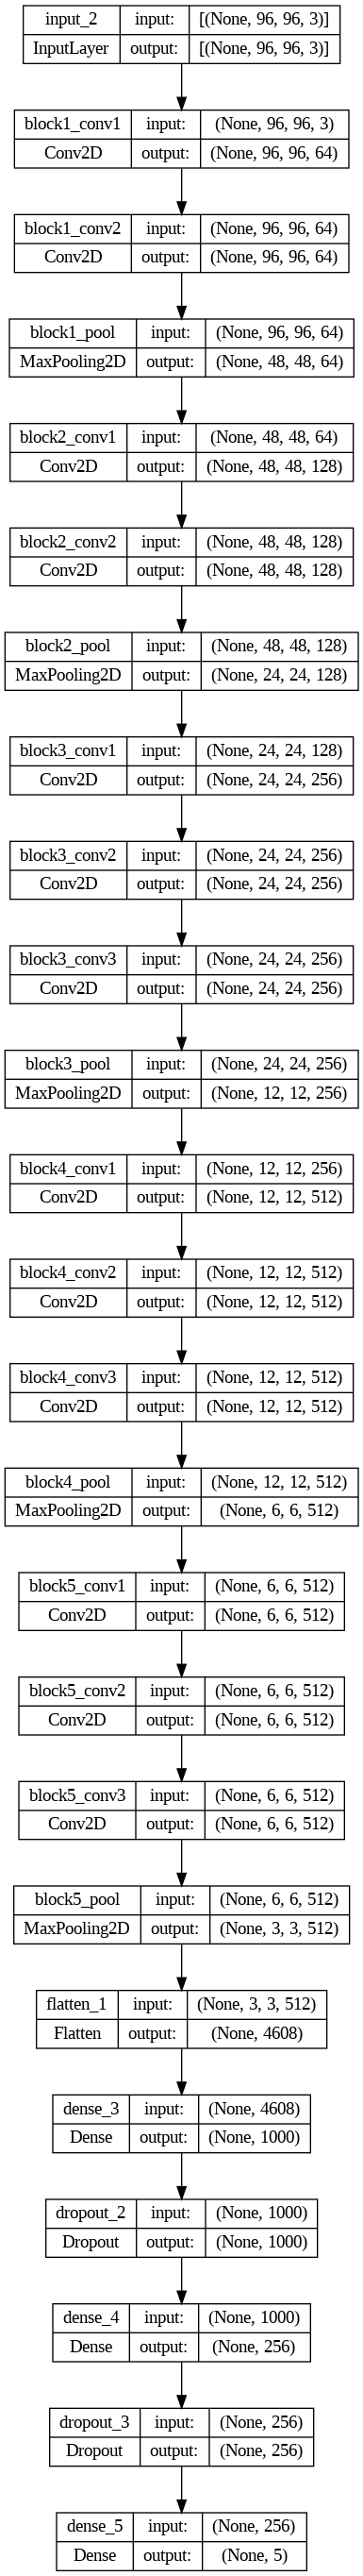

In [4]:
#Get models architecture

keras.utils.plot_model(classifier, to_file="classifier.png", show_shapes=True)